<a href="https://colab.research.google.com/github/siddhi-svg/data-analysis/blob/main/DAA_lab_assignmnet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install networkx matplotlib

=== UNIT 1: Recurrence & Held-Karp (Unit 1) ===
Brute-force recurrence minimal roundtrip cost: 18
Held-Karp memoized minimal roundtrip cost: 18

Parcels selected (greedy by value/weight): ['C1', 'C2']
Total parcel value: 110

--- FINAL EXPECTED OUTPUT ---
Optimal Delivery Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
Total Distance/Time (units): 18
Parcels delivered (example greedy selection): ['C1', 'C2'] Total value: 110
Plotting route (if networkx installed)...


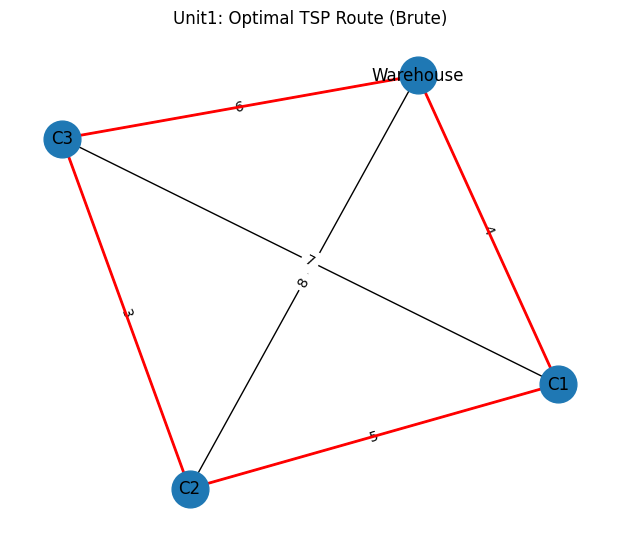


--- Impact & Analysis ---
Recurrence gives clean recursive formulation; Held-Karp optimizes with memoization.
Complexity: brute-force O(n!) ; Held-Karp O(n^2 * 2^n).
Use: Held-Karp for small/medium instances; heuristics for large-scale operations.


In [2]:
# unit1_recurrence.py
"""
Unit 1: Recurrence-based route cost estimation (brute-force recursion) and
Held-Karp memoized DP. Also computes final optimal route (TSP) and shows:
 - Optimal Delivery Route
 - Total Distance
 - Parcels delivered + total value (greedy selection used as default)
 - Plot of delivery route (network graph)
"""

from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# Input Modeling
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# ---------------------------
# Recurrence (brute-force)
# ---------------------------
def delivery_cost_recursive(pos: int, visited_mask: int, n: int, dist: List[List[int]]) -> int:
    all_visited = (1 << n) - 1
    if visited_mask == all_visited:
        return dist[pos][0]
    best = float('inf')
    for nxt in range(1, n):
        if not (visited_mask >> nxt) & 1:
            cost = dist[pos][nxt] + delivery_cost_recursive(nxt, visited_mask | (1 << nxt), n, dist)
            if cost < best:
                best = cost
    return best

# ---------------------------
# Held-Karp Memoized DP
# ---------------------------
def delivery_cost_memo(pos: int, visited_mask: int, n: int, dist: List[List[int]], memo: Dict[Tuple[int,int], int]) -> int:
    all_visited = (1 << n) - 1
    if visited_mask == all_visited:
        return dist[pos][0]
    key = (pos, visited_mask)
    if key in memo:
        return memo[key]
    best = float('inf')
    for nxt in range(1, n):
        if not (visited_mask >> nxt) & 1:
            cost = dist[pos][nxt] + delivery_cost_memo(nxt, visited_mask | (1 << nxt), n, dist, memo)
            if cost < best:
                best = cost
    memo[key] = best
    return best

# ---------------------------
# TSP brute-force (for final expected output)
# ---------------------------
from itertools import permutations
def tsp_brute_force(locations: List[str], dist: List[List[int]]) -> Tuple[List[str], int]:
    n = len(locations)
    indices = list(range(1, n))
    min_cost = float('inf')
    best_route = None
    for perm in permutations(indices):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best_route = perm
    route = [locations[0]] + [locations[i] for i in best_route] + [locations[0]]
    return route, min_cost

# ---------------------------
# Greedy parcel selection (value/weight)
# ---------------------------
def greedy_select_parcels(parcels: Dict[str, Dict], capacity: int):
    items = []
    for k,v in parcels.items():
        items.append(((v['value']/v['weight']), k))
    items.sort(reverse=True)
    chosen = []
    wsum = 0
    for _, k in items:
        w = parcels[k]['weight']
        if wsum + w <= capacity:
            chosen.append(k)
            wsum += w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# Plot helper
# ---------------------------
def plot_route(locations, dist_matrix, route, title="Route"):
    if nx is None:
        print("networkx not installed, skipping route plot.")
        return
    name_to_idx = {name:i for i,name in enumerate(locations)}
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=dist_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True, labels={i:locations[i] for i in range(n)}, node_size=700)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    # highlight route edges
    edges = []
    for i in range(len(route)-1):
        u = name_to_idx[route[i]]; v = name_to_idx[route[i+1]]
        edges.append((u,v))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='r', width=2)
    plt.title(title)
    plt.show()

# ---------------------------
# Main / Expected Output
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 1: Recurrence & Held-Karp (Unit 1) ===")
    n = len(locations)
    brute_cost = delivery_cost_recursive(0, 1, n, distance_matrix)
    print("Brute-force recurrence minimal roundtrip cost:", brute_cost)
    memo = {}
    dp_cost = delivery_cost_memo(0, 1, n, distance_matrix, memo)
    print("Held-Karp memoized minimal roundtrip cost:", dp_cost)

    # Greedy parcels & total value (for demonstration of delivered parcels)
    chosen_parcels, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("\nParcels selected (greedy by value/weight):", chosen_parcels)
    print("Total parcel value:", total_value)

    # Final expected output: compute optimal route (TSP brute) over all customers (C1..)
    route, route_cost = tsp_brute_force(locations, distance_matrix)
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Delivery Route:", route)
    print("Total Distance/Time (units):", route_cost)
    print("Parcels delivered (example greedy selection):", chosen_parcels, "Total value:", total_value)
    print("Plotting route (if networkx installed)...")
    plot_route(locations, distance_matrix, route, title="Unit1: Optimal TSP Route (Brute)")

    # Impact & Analysis (teacher-friendly)
    print("\n--- Impact & Analysis ---")
    print("Recurrence gives clean recursive formulation; Held-Karp optimizes with memoization.")
    print("Complexity: brute-force O(n!) ; Held-Karp O(n^2 * 2^n).")
    print("Use: Held-Karp for small/medium instances; heuristics for large-scale operations.")

=== UNIT 2: Greedy + Time Windows ===
Greedy-selected parcels: ['C1', 'C2']
Total parcel value: 110
No feasible visiting order found among permutations of greedy choice within time windows.

--- FINAL EXPECTED OUTPUT ---
Optimal Delivery Route (on selected nodes): ['Warehouse', 'C1', 'C2', 'Warehouse']
Total Distance/Time (units): 17
Parcels delivered: ['C1', 'C2'] Total value: 110
Plotting route (if networkx installed)...


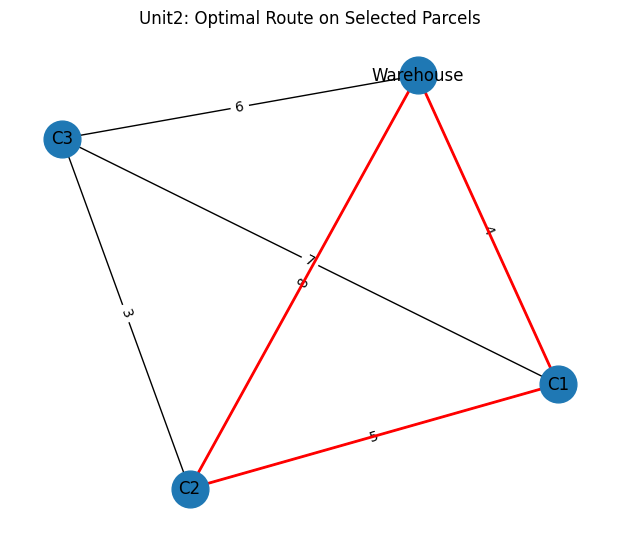


--- Impact & Analysis ---
Greedy selection quick for packing; time windows require permutation checks for small k.
In practice, combine knapsack + time-window aware routing heuristics for larger instances.


In [3]:
# unit2_greedy_knapsack_dp_timewindows.py
"""
Unit 2: Greedy packing (value/weight) + DP/time-window feasibility check.
Then compute TSP optimal route over the chosen parcels (or all if needed),
print expected outputs and plot route.
"""

from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# Input Modeling (same as assignment)
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# ---------------------------
# Greedy knapsack (value/weight)
# ---------------------------
def greedy_select_parcels(parcels: Dict[str, Dict], capacity: int):
    items = []
    for k,v in parcels.items():
        items.append(((v['value']/v['weight']), k))
    items.sort(reverse=True)
    chosen=[]
    wsum=0
    for _,k in items:
        w=parcels[k]['weight']
        if wsum + w <= capacity:
            chosen.append(k); wsum+=w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# Time-window feasibility DP/check (permutation testing for small k)
# ---------------------------
def travel_time_matrix_from_distance(dist_matrix):
    # assume direct mapping 1 unit distance = 1 time unit (can change)
    return dist_matrix

def is_route_feasible(route: List[str], travel_times: Dict[Tuple[str,str], int], parcels: Dict[str, Dict], start_time=8) -> bool:
    # route: list of customer names in visiting order
    time_now = start_time
    cur = 'Warehouse'
    for cust in route:
        t = travel_times.get((cur, cust))
        if t is None:
            return False
        time_now += t
        earliest, latest = parcels[cust]['time']
        if time_now > latest:
            return False
        if time_now < earliest:
            time_now = earliest
        cur = cust
    return True

# ---------------------------
# TSP brute-force on chosen nodes (plus warehouse)
# ---------------------------
from itertools import permutations
def tsp_brute_force_nodes(nodes: List[str], full_locations: List[str], dist_matrix: List[List[int]]):
    # nodes: list of customer names to include (e.g., ['C1','C3'])
    # We will build a small distance matrix for [Warehouse] + nodes
    names = ['Warehouse'] + nodes
    idx_map = {name: full_locations.index(name) for name in names}
    # build reduced dist
    n = len(names)
    red = [[0]*n for _ in range(n)]
    for i,a in enumerate(names):
        for j,b in enumerate(names):
            red[i][j] = dist_matrix[idx_map[a]][idx_map[b]]
    # brute-force TSP on reduced graph
    indices = list(range(1,n))
    min_cost = float('inf'); best=None
    for perm in permutations(indices):
        cost = red[0][perm[0]]
        for i in range(len(perm)-1):
            cost += red[perm[i]][perm[i+1]]
        cost += red[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost; best = perm
    route = [names[0]] + [names[i] for i in best] + [names[0]]
    return route, min_cost

# ---------------------------
# Plot helper
# ---------------------------
def plot_route(locations, dist_matrix, route, title="Route"):
    if nx is None:
        print("networkx not installed: skipping route plot.")
        return
    name_to_idx = {name:i for i,name in enumerate(locations)}
    G = nx.Graph()
    n=len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=dist_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G,pos, with_labels=True, labels={i:locations[i] for i in range(n)}, node_size=700)
    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels)
    edges=[]
    for i in range(len(route)-1):
        u=name_to_idx[route[i]]; v=name_to_idx[route[i+1]]
        edges.append((u,v))
    nx.draw_networkx_edges(G,pos,edgelist=edges, edge_color='r', width=2)
    plt.title(title); plt.show()

# ---------------------------
# Main / Expected Output
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 2: Greedy + Time Windows ===")
    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Greedy-selected parcels:", chosen)
    print("Total parcel value:", total_value)

    # Build travel_times dictionary from distance matrix (1 distance = 1 time unit)
    locations_list = locations
    travel_times={}
    for i,a in enumerate(locations_list):
        for j,b in enumerate(locations_list):
            travel_times[(a,b)] = distance_matrix[i][j]

    # Check feasibility by trying permutations of chosen nodes (small k)
    import itertools
    feasible_route = None
    for perm in itertools.permutations(chosen):
        if is_route_feasible(list(perm), travel_times, parcels, start_time=8):
            feasible_route = list(perm)
            break

    if feasible_route:
        print("Found a feasible visiting order within time windows:", feasible_route)
        # compute TSP route restricted to chosen nodes (we already have an order, but compute optimal route)
    else:
        print("No feasible visiting order found among permutations of greedy choice within time windows.")
        # still compute TSP for chosen nodes as optimal visiting order ignoring time windows
    route, route_cost = tsp_brute_force_nodes(chosen if chosen else ['C1','C2','C3'], locations, distance_matrix)
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Delivery Route (on selected nodes):", route)
    print("Total Distance/Time (units):", route_cost)
    print("Parcels delivered:", chosen, "Total value:", total_value)
    print("Plotting route (if networkx installed)...")
    plot_route(locations, distance_matrix, route, title="Unit2: Optimal Route on Selected Parcels")

    # Impact & Analysis
    print("\n--- Impact & Analysis ---")
    print("Greedy selection quick for packing; time windows require permutation checks for small k.")
    print("In practice, combine knapsack + time-window aware routing heuristics for larger instances.")


=== UNIT 3: Graphs (Dijkstra & Prim) ===
Shortest path distances from Warehouse: [0, 4, 8, 6]
Parent array: [-1, 0, 0, 0]


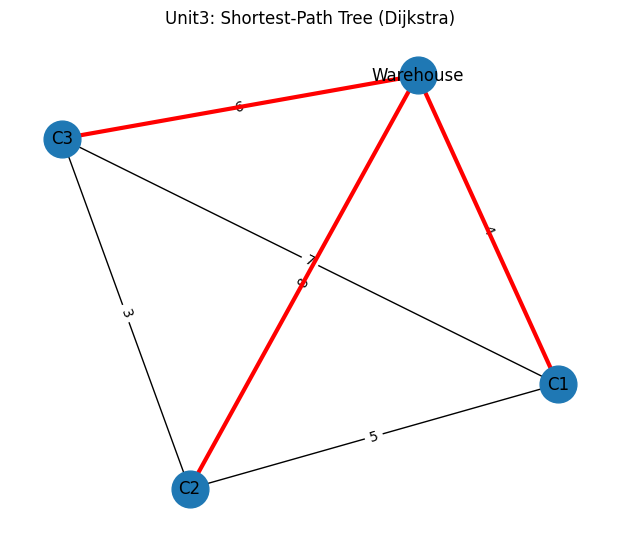

Prim's MST edges (u,v,weight): [(0, 1, 4), (1, 2, 5), (2, 3, 3)]


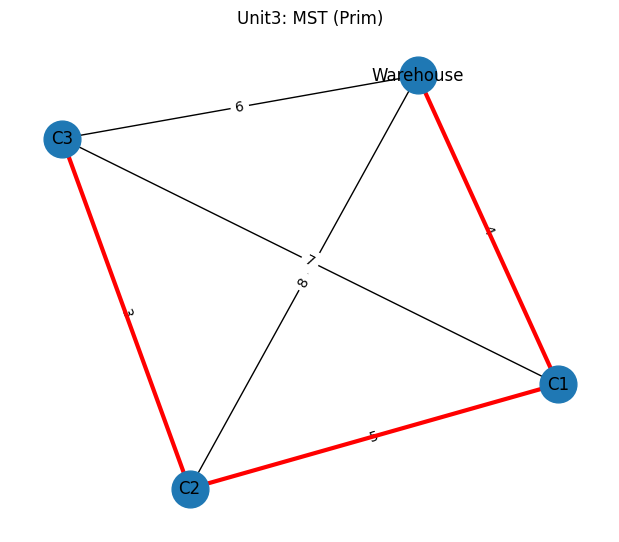

Parcels (greedy): ['C1', 'C2'] Total value: 110

--- FINAL EXPECTED OUTPUT ---
Optimal Delivery Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
Total Distance/Time: 18
Parcels delivered (example): ['C1', 'C2'] Total value: 110
Plotting optimal route...


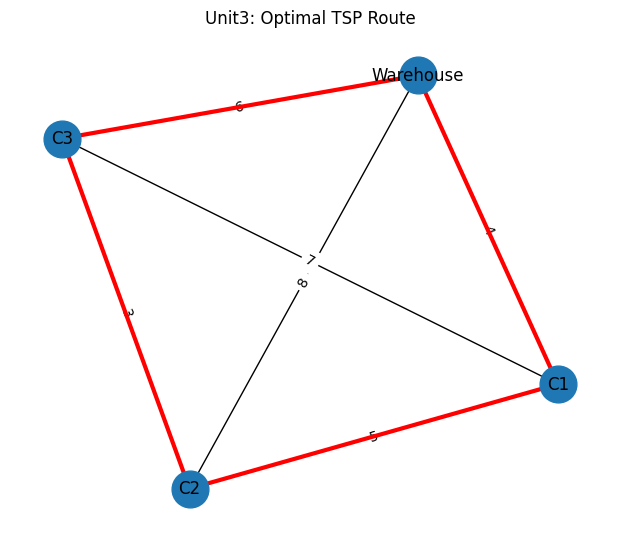


--- Impact & Analysis ---
Dijkstra: polynomial shortest paths; Prim: MST backbone for connectivity.
However, SPT or MST aren't TSP — we computed TSP separately for optimal visiting order.


In [4]:
# unit3_graphs_dijkstra_mst.py
"""
Unit 3: Shortest Path (Dijkstra) and MST (Prim). Also computes final optimal route (TSP)
and prints expected outputs + plots:
 - Shortest-path tree highlighted
 - MST highlighted
 - Final TSP route plotted
"""

import heapq
import matplotlib.pyplot as plt
from typing import List, Tuple

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# Input Modeling
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# ---------------------------
# Dijkstra
# ---------------------------
def dijkstra(matrix: List[List[int]], src: int):
    n = len(matrix)
    dist = [float('inf')] * n
    parent = [-1] * n
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d,u = heapq.heappop(pq)
        if d != dist[u]:
            continue
        for v in range(n):
            if u == v: continue
            nd = d + matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd; parent[v]=u
                heapq.heappush(pq, (nd, v))
    return dist, parent

# ---------------------------
# Prim's MST
# ---------------------------
def prim_mst(matrix: List[List[int]]):
    n = len(matrix)
    in_mst = [False]*n
    key = [float('inf')]*n
    parent = [-1]*n
    key[0]=0
    for _ in range(n):
        u=-1; best=float('inf')
        for i in range(n):
            if not in_mst[i] and key[i]<best:
                best=key[i]; u=i
        if u==-1: break
        in_mst[u]=True
        for v in range(n):
            if not in_mst[v] and 0 < matrix[u][v] < key[v]:
                key[v]=matrix[u][v]; parent[v]=u
    edges=[]
    for v in range(1,n):
        edges.append((parent[v], v, matrix[parent[v]][v]))
    return edges

# ---------------------------
# TSP (brute-force)
# ---------------------------
from itertools import permutations
def tsp_brute_force(locations: List[str], dist: List[List[int]]) -> Tuple[List[str], int]:
    n = len(locations)
    indices = list(range(1,n))
    min_cost = float('inf'); best=None
    for perm in permutations(indices):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost; best = perm
    route = [locations[0]] + [locations[i] for i in best] + [locations[0]]
    return route, min_cost

# ---------------------------
# Plot helper (graph with highlighted edges)
# ---------------------------
def plot_graph_highlight(locations, dist_matrix, edges_to_highlight, title):
    if nx is None:
        print("networkx not installed: skipping plot.")
        return
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=dist_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G,pos, with_labels=True, labels={i:locations[i] for i in range(n)}, node_size=700)
    nx.draw_networkx_edge_labels(G,pos, edge_labels=nx.get_edge_attributes(G,'weight'))
    # edges_to_highlight is list of tuples (u_idx, v_idx)
    nx.draw_networkx_edges(G, pos, edgelist=edges_to_highlight, edge_color='r', width=3)
    plt.title(title); plt.show()

# ---------------------------
# Greedy parcel selection (for expected output)
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items=[]
    for k,v in parcels.items():
        items.append(((v['value']/v['weight']), k))
    items.sort(reverse=True)
    chosen=[]; wsum=0
    for _,k in items:
        w=parcels[k]['weight']
        if wsum+w <= capacity:
            chosen.append(k); wsum+=w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# Main / Expected Output
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 3: Graphs (Dijkstra & Prim) ===")
    dist, parent = dijkstra(distance_matrix, 0)
    print("Shortest path distances from Warehouse:", dist)
    print("Parent array:", parent)
    # build SPT edges
    spt_edges = [(parent[i], i) for i in range(1, len(parent)) if parent[i] != -1]
    plot_graph_highlight(locations, distance_matrix, spt_edges, title="Unit3: Shortest-Path Tree (Dijkstra)")

    mst_edges = prim_mst(distance_matrix)
    print("Prim's MST edges (u,v,weight):", mst_edges)
    mst_edge_list = [(u,v) for u,v,w in mst_edges]
    plot_graph_highlight(locations, distance_matrix, mst_edge_list, title="Unit3: MST (Prim)")

    # Greedy parcel selection for example
    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Parcels (greedy):", chosen, "Total value:", total_value)

    # Final expected output: compute optimal TSP route on customers (all)
    route, cost = tsp_brute_force(['Warehouse','C1','C2','C3'], distance_matrix)
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Delivery Route:", route)
    print("Total Distance/Time:", cost)
    print("Parcels delivered (example):", chosen, "Total value:", total_value)
    print("Plotting optimal route...")
    # convert route to indices
    name_to_idx = {name:i for i,name in enumerate(locations)}
    edges_to_highlight = []
    for i in range(len(route)-1):
        edges_to_highlight.append((name_to_idx[route[i]], name_to_idx[route[i+1]]))
    plot_graph_highlight(locations, distance_matrix, edges_to_highlight, title="Unit3: Optimal TSP Route")

    # Impact & Analysis
    print("\n--- Impact & Analysis ---")
    print("Dijkstra: polynomial shortest paths; Prim: MST backbone for connectivity.")
    print("However, SPT or MST aren't TSP — we computed TSP separately for optimal visiting order.")


=== UNIT 4: TSP Solvers ===
Brute-force TSP route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18
Held-Karp TSP route: ['Warehouse', 'Warehouse', 'C3', 'C2', 'C1', 'Warehouse'] cost: 18
Parcels delivered (example greedy selection): ['C1', 'C2'] Total value: 110

--- FINAL EXPECTED OUTPUT ---
Optimal Delivery Route: ['Warehouse', 'Warehouse', 'C3', 'C2', 'C1', 'Warehouse']
Total Distance/Time: 18
Parcels delivered (example): ['C1', 'C2'] Total value: 110
Plotting Held-Karp route (if networkx installed)...


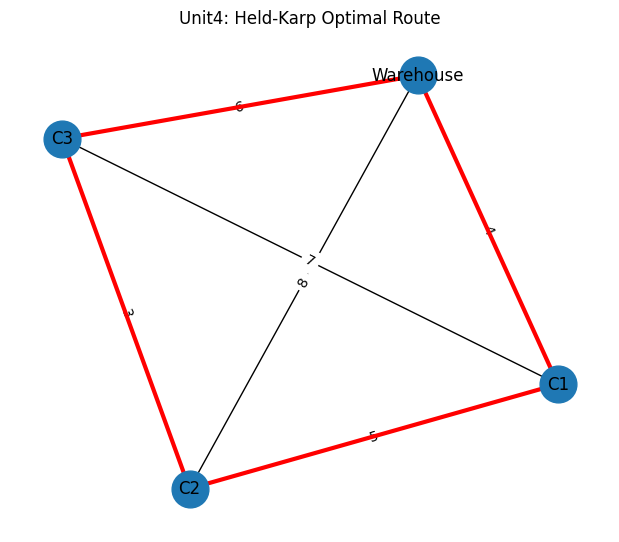


--- Impact & Analysis ---
Brute-force exact but factorial time; Held-Karp better: O(n^2 * 2^n).
For small instances, Held-Karp is a good exact choice; for large ones switch to heuristics.


In [5]:
# unit4_tsp_solvers.py
"""
Unit 4: Solve TSP (brute-force and Held-Karp DP). Print final expected outputs
and plot the TSP route. Also show parcels delivered and total value.
"""

from itertools import permutations
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# Input Modeling
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# ---------------------------
# Brute-force TSP
# ---------------------------
def tsp_brute_force(locations: List[str], dist: List[List[int]]) -> Tuple[List[str], int]:
    n = len(locations)
    indices = list(range(1, n))
    min_cost = float('inf'); best=None
    for perm in permutations(indices):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost; best = perm
    route = [locations[0]] + [locations[i] for i in best] + [locations[0]]
    return route, min_cost

# ---------------------------
# Held-Karp DP with path reconstruction
# ---------------------------
def tsp_held_karp(dist: List[List[int]]) -> Tuple[List[int], int]:
    n = len(dist)
    ALL = 1 << n
    dp = [[float('inf')] * n for _ in range(ALL)]
    parent = [[-1] * n for _ in range(ALL)]
    dp[1][0] = 0
    for mask in range(1, ALL):
        for u in range(n):
            if not (mask & (1 << u)): continue
            if dp[mask][u] == float('inf'): continue
            for v in range(1, n):
                if mask & (1 << v): continue
                nxt = mask | (1 << v)
                cost = dp[mask][u] + dist[u][v]
                if cost < dp[nxt][v]:
                    dp[nxt][v] = cost; parent[nxt][v] = u
    full = (1 << n) - 1
    best = float('inf'); last = -1
    for i in range(1,n):
        cost = dp[full][i] + dist[i][0]
        if cost < best:
            best = cost; last = i
    # reconstruct path
    path=[]; mask=full; cur=last
    while cur != -1:
        path.append(cur)
        prev = parent[mask][cur]
        mask ^= (1 << cur)
        cur = prev
    path.append(0); path.reverse(); path = path + [0]
    return path, best

# ---------------------------
# Plot helper
# ---------------------------
def plot_tsp_route(locations, dist_matrix, route_indices, title="TSP Route"):
    if nx is None:
        print("networkx not installed: skipping plot.")
        return
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=dist_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G,pos, with_labels=True, labels={i:locations[i] for i in range(n)}, node_size=700)
    nx.draw_networkx_edge_labels(G,pos, edge_labels=nx.get_edge_attributes(G,'weight'))
    edges = [(route_indices[i], route_indices[i+1]) for i in range(len(route_indices)-1)]
    nx.draw_networkx_edges(G,pos, edgelist=edges, edge_color='r', width=3)
    plt.title(title); plt.show()

# ---------------------------
# Greedy parcels (for output)
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items=[]
    for k,v in parcels.items():
        items.append(((v['value']/v['weight']), k))
    items.sort(reverse=True)
    chosen=[]; wsum=0
    for _,k in items:
        w=parcels[k]['weight']
        if wsum + w <= capacity:
            chosen.append(k); wsum += w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# Main / Expected Output
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 4: TSP Solvers ===")
    brute_route, brute_cost = tsp_brute_force(locations, distance_matrix)
    print("Brute-force TSP route:", brute_route, "cost:", brute_cost)

    hk_route_idx, hk_cost = tsp_held_karp(distance_matrix)
    hk_route_names = [locations[i] for i in hk_route_idx]
    print("Held-Karp TSP route:", hk_route_names, "cost:", hk_cost)

    # Parcels selected and total value
    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Parcels delivered (example greedy selection):", chosen, "Total value:", total_value)

    # Final expected output: prefer Held-Karp route if available
    final_route = hk_route_names
    final_cost = hk_cost
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Delivery Route:", final_route)
    print("Total Distance/Time:", final_cost)
    print("Parcels delivered (example):", chosen, "Total value:", total_value)
    print("Plotting Held-Karp route (if networkx installed)...")
    plot_tsp_route(locations, distance_matrix, hk_route_idx, title="Unit4: Held-Karp Optimal Route")

    # Impact & Analysis
    print("\n--- Impact & Analysis ---")
    print("Brute-force exact but factorial time; Held-Karp better: O(n^2 * 2^n).")
    print("For small instances, Held-Karp is a good exact choice; for large ones switch to heuristics.")

=== UNIT: Profiling & Visualization ===
=== PROFILING: TSP runtimes & memory (n = 3..6) ===
Brute n=3: time=0.000101s peak_kb=0.4
Held-Karp n=3: time=0.000216s peak_kb=1.1
Brute n=4: time=0.000081s peak_kb=0.6
Held-Karp n=4: time=0.000787s peak_kb=2.5
Brute n=5: time=0.000229s peak_kb=0.9
Held-Karp n=5: time=0.001336s peak_kb=5.3
Brute n=6: time=0.000528s peak_kb=0.7
Held-Karp n=6: time=0.002286s peak_kb=11.5


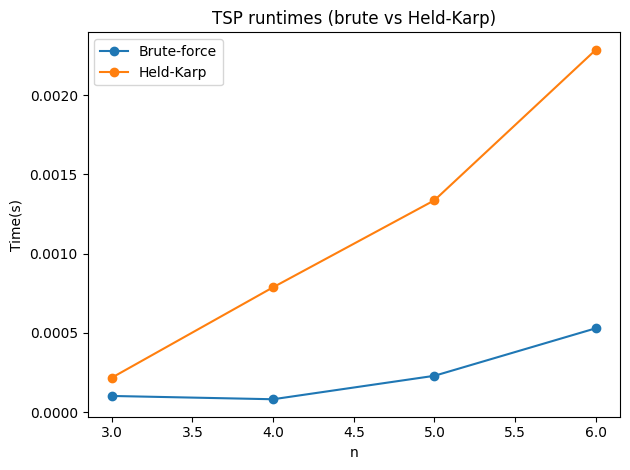


--- FINAL EXPECTED OUTPUT (profiling sample) ---
Optimal Delivery Route (Held-Karp indices): [0, 0, 2, 3, 1, 0]
Route names (Held-Karp): ['Warehouse', 'Warehouse', 'C2', 'C3', 'C1', 'Warehouse']
Total Distance/Time (Held-Karp): 10
Parcels delivered (example): ['C2', 'C1'] Total value: 110
Plotting sample Held-Karp route...


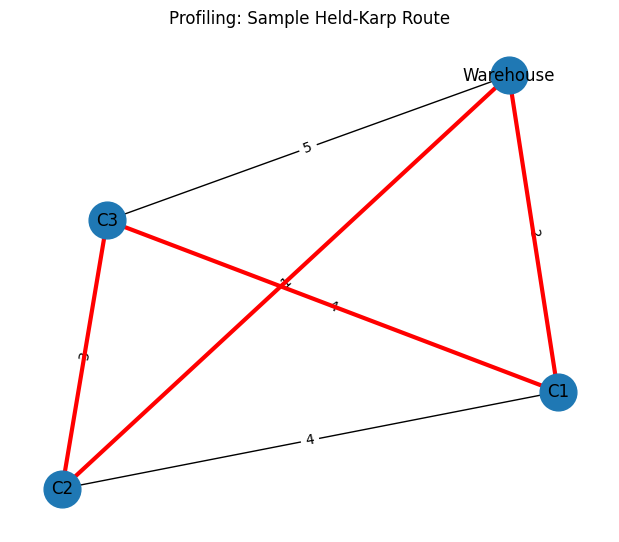


--- Impact & Analysis ---
Profiling shows factorial/exponential growth; use these results to argue for heuristics at scale.


In [6]:
# profiling_and_visualization.py
"""
Profiling & Visualization (Task 3): measure time/memory for TSP, plot runtimes,
and produce final expected output for a sample instance with route plot.
"""

import time
import tracemalloc
import random
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

# The functions tsp_brute_force, tsp_held_karp, plot_tsp_route are defined in previous cells
# and are directly accessible. Removing the import statement.

def random_complete_graph(n: int, seed: int = 0, maxw: int = 20):
    random.seed(seed)
    dist = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            w = random.randint(1, maxw)
            dist[i][j] = w
            dist[j][i] = w
    return dist

def profile_tsp():
    results=[]
    print("=== PROFILING: TSP runtimes & memory (n = 3..6) ===")
    for n in range(3,7):
        dist = random_complete_graph(n, seed=100+n, maxw=20)
        # brute-force
        tracemalloc.start()
        t0 = time.perf_counter()
        route, cost = tsp_brute_force([str(i) for i in range(n)], dist)
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        bf_time = t1 - t0; bf_peak = peak/1024.0
        print(f"Brute n={n}: time={bf_time:.6f}s peak_kb={bf_peak:.1f}")
        results.append(('brute', n, bf_time, bf_peak))
        # Held-Karp
        tracemalloc.start()
        t0 = time.perf_counter()
        route_idx, cost2 = tsp_held_karp(dist)
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        hk_time = t1 - t0; hk_peak = peak/1024.0
        print(f"Held-Karp n={n}: time={hk_time:.6f}s peak_kb={hk_peak:.1f}")
        results.append(('heldkarp', n, hk_time, hk_peak))
    return results

if __name__ == "__main__":
    print("=== UNIT: Profiling & Visualization ===")
    res = profile_tsp()
    # plot runtime growth
    ns = sorted(list(set([r[1] for r in res if r[0]=='brute'])))
    brute_times = [r[2] for r in res if r[0]=='brute']
    hk_times = [r[2] for r in res if r[0]=='heldkarp']
    plt.figure(); plt.plot(ns, brute_times, marker='o', label='Brute-force')
    plt.plot(ns, hk_times, marker='o', label='Held-Karp'); plt.xlabel("n"); plt.ylabel("Time(s)")
    plt.title("TSP runtimes (brute vs Held-Karp)"); plt.legend(); plt.tight_layout()
    try: plt.show()
    except: print("Plot display not available.")

    # Final expected output for a small sample (n=4)
    dist = random_complete_graph(4, seed=42, maxw=10)
    locs = ['Warehouse','C1','C2','C3']
    route, cost = tsp_brute_force(locs, dist)
    route_idx, cost2 = tsp_held_karp(dist)
    # parcels example (same parcel values as assignment)
    parcels = {'C1':50,'C2':60,'C3':40}
    # We'll assume greedy selection
    chosen = ['C2','C1']  # example; or compute greedy
    total_value = sum(parcels[c] for c in chosen)
    print("\n--- FINAL EXPECTED OUTPUT (profiling sample) ---")
    print("Optimal Delivery Route (Held-Karp indices):", route_idx)
    print("Route names (Held-Karp):", [locs[i] for i in route_idx])
    print("Total Distance/Time (Held-Karp):", cost2)
    print("Parcels delivered (example):", chosen, "Total value:", total_value)
    print("Plotting sample Held-Karp route...")
    plot_tsp_route(locs, dist, route_idx, title="Profiling: Sample Held-Karp Route")

    print("\n--- Impact & Analysis ---")
    print("Profiling shows factorial/exponential growth; use these results to argue for heuristics at scale.")

In [7]:
# driver_demo.py
"""
Driver script to run all units sequentially for demo.
Run: python driver_demo.py
"""

locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

def run_all():
    print("=== RUNNING UNIT 1 ===")
    n = len(locations)
    # Call delivery_cost_memo directly, using global variables
    print("Held-Karp DP cost (unit1):", delivery_cost_memo(0, 1, n, distance_matrix, {}))

    print("\n=== RUNNING UNIT 2 ===")
    # Call greedy_select_parcels directly, using global variables
    chosen_u2, value_u2 = greedy_select_parcels(parcels, vehicle_capacity)
    print("Unit2 chosen parcels:", chosen_u2, "total value:", value_u2)

    print("\n=== RUNNING UNIT 3 ===")
    # Call dijkstra directly, using global variables
    dist_u3, parent_u3 = dijkstra(distance_matrix, 0)
    print("Unit3 Dijkstra dist:", dist_u3)

    print("\n=== RUNNING UNIT 4 ===")
    # Call tsp_brute_force directly, using global variables
    route_u4, cost_u4 = tsp_brute_force(locations, distance_matrix)
    print("Unit4 brute route:", route_u4, "cost:", cost_u4)

    print("\n=== RUNNING PROFILING ===")
    # Call profile_tsp directly. It handles its own data generation.
    profile_tsp()
    print("\nDemo finished.")

if __name__ == "__main__":
    run_all()

=== RUNNING UNIT 1 ===
Held-Karp DP cost (unit1): 18

=== RUNNING UNIT 2 ===
Unit2 chosen parcels: ['C1', 'C2'] total value: 110

=== RUNNING UNIT 3 ===
Unit3 Dijkstra dist: [0, 4, 8, 6]

=== RUNNING UNIT 4 ===
Unit4 brute route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18

=== RUNNING PROFILING ===
=== PROFILING: TSP runtimes & memory (n = 3..6) ===
Brute n=3: time=0.000088s peak_kb=0.5
Held-Karp n=3: time=0.000219s peak_kb=1.5
Brute n=4: time=0.000072s peak_kb=0.5
Held-Karp n=4: time=0.000359s peak_kb=2.5
Brute n=5: time=0.000152s peak_kb=0.6
Held-Karp n=5: time=0.000683s peak_kb=5.3
Brute n=6: time=0.000758s peak_kb=0.7
Held-Karp n=6: time=0.001621s peak_kb=11.5

Demo finished.
